In [7]:
# dataDir = "/home/ababil/BUET/AV/csv"
# dataDir = "D:/AV/Code/location-2"
dataDir = "D:/desktop_alternative/buetav/behavior-hypotheses-main/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [8]:
exec(open('init_notebook.py').read())

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [11]:
sceneId = 210
sceneId2 = 211
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
pedDf2 = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId2}-pedestrians.csv"))
# otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [12]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        # xAccCol='sceneXAcceleration',
        # yAccCol='sceneYAcceleration',
        accelerationCol='acceleration'
        
    
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = -10.0,
    maxAcceleration = 10.0,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)

transformer.deriveSpeed(pedDf2)
transformer.deriveDisplacements(pedDf2)
transformer.deriveAcceleration(pedDf2)

TypeError: ColMapper.__init__() got an unexpected keyword argument 'accelerationCol'

In [7]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


7600

In [8]:
startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()

list1 = [startingDf['speed'], midDf['speed'], endDf['speed']]

In [9]:
cleanPedDf.head()

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772


In [10]:
# cleanPedDf[cleanPedDf['uniqueTrackId'] == 18023].copy()

In [11]:
uniqueTrackIds = cleanPedDf['uniqueTrackId'].unique()
len(uniqueTrackIds)

170

In [12]:
newData = { 'uniqueTrackId': uniqueTrackIds }
uniquePedDf = pd.DataFrame(newData)
uniquePedDf.head()

,uniqueTrackId
0,18023
1,18069
2,18090
3,18121
4,18134


In [13]:
uniquePedDf['startingTopSpeed'] = [0] * len(uniquePedDf)
uniquePedDf['midTopSpeed'] = [0] * len(uniquePedDf)
uniquePedDf['endTopSpeed'] = [0] * len(uniquePedDf)

uniquePedDf.head()

,uniqueTrackId,startingTopSpeed,midTopSpeed,endTopSpeed
0,18023,0,0,0
1,18069,0,0,0
2,18090,0,0,0
3,18121,0,0,0
4,18134,0,0,0


In [14]:
trackId = 18023
def putTopSpeed(trackId, df):
    uniqueDf = df[df['uniqueTrackId'] == trackId].copy() 
    if (not uniqueDf['speed'].empty):
        return max(uniqueDf['speed'])
    else:
        return 0

def putStartingTopSpeed(trackId):
    uniqueStartingDf = startingDf[startingDf['uniqueTrackId'] == trackId].copy() 
    if (not uniqueStartingDf['speed'].empty):
        return max(uniqueStartingDf['speed'])
    else:
        return 0
    
def putMidTopSpeed(trackId):
    uniqueMidDf = midDf[midDf['uniqueTrackId'] == trackId].copy() 
    return max(uniqueMidDf['speed'])

def putEndTopSpeed(trackId):
    uniqueEndDf = endDf[endDf['uniqueTrackId'] == trackId].copy() 
    return max(uniqueEndDf['speed'])

print(putStartingTopSpeed(trackId), putMidTopSpeed(trackId), putEndTopSpeed(trackId))
print(putTopSpeed(trackId, startingDf))

0.4997371409051065 0.515984362650666 0.4783609332920143
0.4997371409051065


In [15]:
uniquePedDf['startingTopSpeed'] = uniquePedDf['uniqueTrackId'].apply(putTopSpeed, df=startingDf)
uniquePedDf['midTopSpeed'] = uniquePedDf['uniqueTrackId'].apply(putTopSpeed, df=midDf)
uniquePedDf['endTopSpeed'] = uniquePedDf['uniqueTrackId'].apply(putTopSpeed, df=endDf)

In [16]:
uniquePedDf

,uniqueTrackId,startingTopSpeed,midTopSpeed,endTopSpeed
0,18023,0.499737,0.515984,0.478361
1,18069,0.648834,0.653242,0.584781
2,18090,0.802478,0.763060,0.739917
3,18121,0.618203,0.625436,0.603101
4,18134,0.479898,0.566713,0.452462
...,...,...,...,...
165,29353,0.603601,0.616769,0.580479
166,29439,1.065763,1.115675,1.073348
167,29498,0.761582,0.765139,0.708525
168,29530,0.681933,0.690485,0.659207


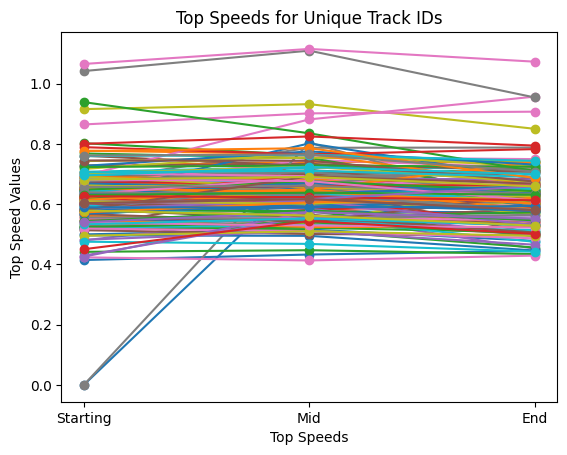

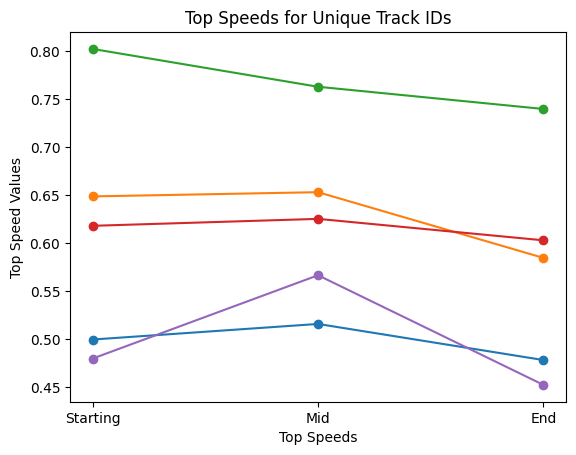

In [17]:
# import pandas as pd
# import matplotlib.pyplot as plt

# Assuming you already have the 'uniquePedDf' DataFrame
def showSpeedFluctuationPlot(uniquePedDf):
    # Group the data by 'uniqueTrackId'
    grouped = uniquePedDf.groupby('uniqueTrackId')

    # Create a line plot for each uniqueTrackId
    for track_id, group_df in grouped:
        plt.plot(['Starting', 'Mid', 'End'], [group_df['startingTopSpeed'].values[0], group_df['midTopSpeed'].values[0], group_df['endTopSpeed'].values[0]], label=f'Track {track_id}', marker='o')

    # Add labels and legend
    plt.xlabel('Top Speeds')
    plt.ylabel('Top Speed Values')
    plt.title('Top Speeds for Unique Track IDs')
    # plt.legend()

    # Show the plot
    plt.show()

showSpeedFluctuationPlot(uniquePedDf)
showSpeedFluctuationPlot(uniquePedDf.head())

In [18]:
#! generate statistics based on how many pedestrians increase their top speed when moving to mid, again moving to end

def checkIncSpeed(row, col1, col2):
    return row[col1] < row[col2]

tempDf = pd.DataFrame()

uniquePedDf['startToMidIncrease'] = uniquePedDf.apply(checkIncSpeed, col1='startingTopSpeed', col2='midTopSpeed', axis=1)
uniquePedDf['midToEndIncrease'] = uniquePedDf.apply(checkIncSpeed, col1='midTopSpeed', col2='endTopSpeed', axis=1)

uniquePedDf

,uniqueTrackId,startingTopSpeed,midTopSpeed,endTopSpeed,startToMidIncrease,midToEndIncrease
0,18023,0.499737,0.515984,0.478361,True,False
1,18069,0.648834,0.653242,0.584781,True,False
2,18090,0.802478,0.763060,0.739917,False,False
3,18121,0.618203,0.625436,0.603101,True,False
4,18134,0.479898,0.566713,0.452462,True,False
...,...,...,...,...,...,...
165,29353,0.603601,0.616769,0.580479,True,False
166,29439,1.065763,1.115675,1.073348,True,False
167,29498,0.761582,0.765139,0.708525,True,False
168,29530,0.681933,0.690485,0.659207,True,False
